In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# packages for graphing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# packages for machine learning
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error

import xgboost
from xgboost import XGBRegressor

import lightgbm
from lightgbm import LGBMRegressor

# packages for bayesian optimization
import skopt
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [2]:
# get package versions
print('Numpy version is:{}'.format(np.__version__))
print('Pandas version is:{}'.format(pd.__version__))
print('Matplotlib version is:{}'.format(matplotlib.__version__))
print('scikit-learn version is:{}'.format(sklearn.__version__))
print('scikit-optimize version is:{}'.format(skopt.__version__))
print('xgboost version is:{}'.format(xgboost.__version__))
print('lightgbm version is:{}'.format(lightgbm.__version__))


Numpy version is:1.26.4
Pandas version is:2.2.3
Matplotlib version is:3.7.2
scikit-learn version is:1.2.2
scikit-optimize version is:0.10.2
xgboost version is:2.0.3
lightgbm version is:4.6.0


In [3]:
# read in training data
train_df= pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')

# look at training datafrane
print('shape of training dataframe is:{}'.format(train_df.shape))
print(train_df.head())

shape of training dataframe is:(90615, 10)
   id Sex  Length  Diameter  Height  Whole weight  Whole weight.1  \
0   0   F   0.550     0.430   0.150        0.7715          0.3285   
1   1   F   0.630     0.490   0.145        1.1300          0.4580   
2   2   I   0.160     0.110   0.025        0.0210          0.0055   
3   3   M   0.595     0.475   0.150        0.9145          0.3755   
4   4   I   0.555     0.425   0.130        0.7820          0.3695   

   Whole weight.2  Shell weight  Rings  
0          0.1465        0.2400     11  
1          0.2765        0.3200     11  
2          0.0030        0.0050      6  
3          0.2055        0.2500     10  
4          0.1600        0.1975      9  


In [4]:
# check for null in training
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


no null values.  1 categorical column: sex all other columns are numeric.  target is rings.

In [5]:
# look at statistics for numeric columns

# numeric columns
num_col= sorted(train_df.select_dtypes(include= np.number).columns.tolist())
# categorical columns
str_col= ['Sex']

train_df[num_col].describe().T


,count,mean,std,min,25%,50%,75%,max
Diameter,90615.0,0.401679,0.098026,0.0550,0.3450,0.4250,0.4700,0.6500
Height,90615.0,0.135464,0.038008,0.0000,0.1100,0.1400,0.1600,1.1300
Length,90615.0,0.517098,0.118217,0.0750,0.4450,0.5450,0.6000,0.8150
Rings,90615.0,9.696794,3.176221,1.0000,8.0000,9.0000,11.0000,29.0000
Shell weight,90615.0,0.225898,0.130203,0.0015,0.1200,0.2250,0.3050,1.0050
Whole weight,90615.0,0.789035,0.457671,0.0020,0.4190,0.7995,1.0675,2.8255
Whole weight.1,90615.0,0.340778,0.204428,0.0010,0.1775,0.3300,0.4630,1.4880
Whole weight.2,90615.0,0.169422,0.100909,0.0005,0.0865,0.1660,0.2325,0.7600
id,90615.0,45307.000000,26158.441658,0.0000,22653.5000,45307.0000,67960.5000,90614.0000


for features, mean and median are similar.  

In [6]:
# make function to show boxplot and histogram

def hist_box_fn(df1, col1, bin1= None):
    # define subplots
    fig0, ax0= plt.subplots(1, 2, figsize= (8, 3), gridspec_kw= {'width_ratios':[2, 1]})
    # adjust spacing
    plt.subplots_adjust(wspace= 0.5)
    # make histogram
    ax0[0].hist(df1[col1], bins= bin1)
    # add average to histogram
    ax0[0].axvline(df1[col1].mean(), color= 'k', linewidth= 2, label= 'Average')
    # add median to histogram
    ax0[0].axvline(df1[col1].median(), color= 'green', linewidth= 2, label= 'Median')
    skew1= np.round(df1[col1].skew(), 3)
    ax0[0].text(0.9, 0.1, 'Skew:{}'.format(skew1), ha= 'center', va= 'center', transform= ax0[0].transAxes)
    # formatting
    ax0[0].set_ylabel('Counts')
    ax0[0].legend(loc= 'upper right')
    # make boxplot
    ax0[1].boxplot(df1[col1])
    ax0[1].set_ylabel(col1)
    # add title
    fig0.suptitle(col1, fontsize= 16)


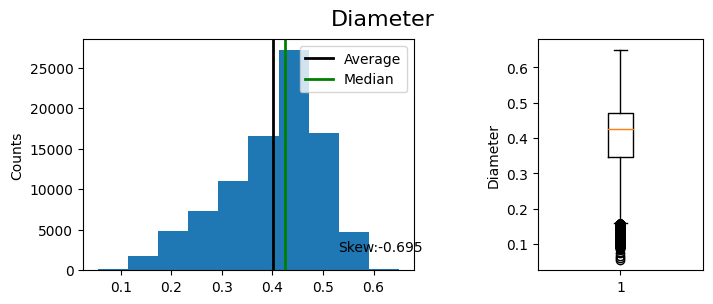

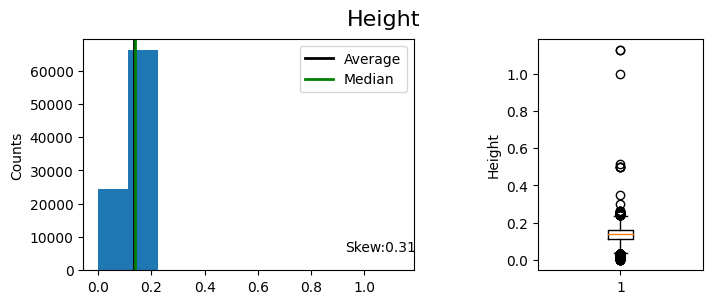

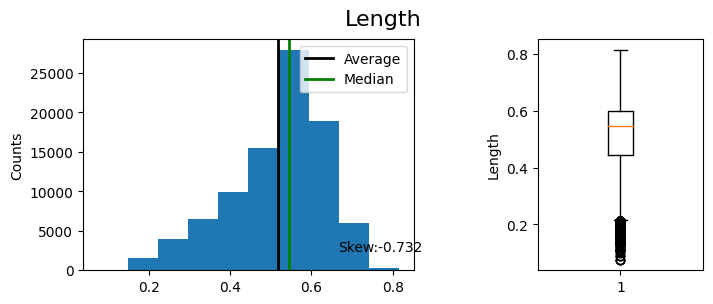

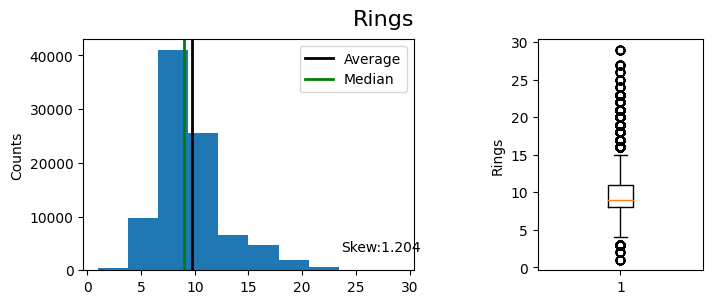

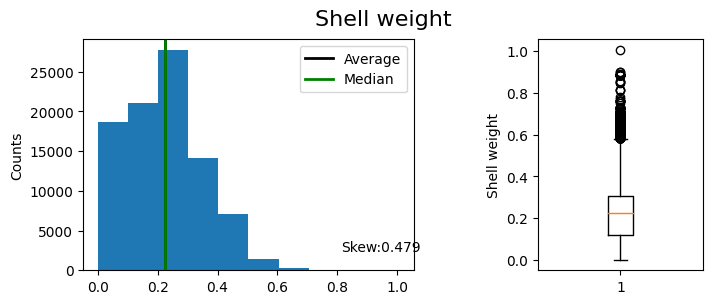

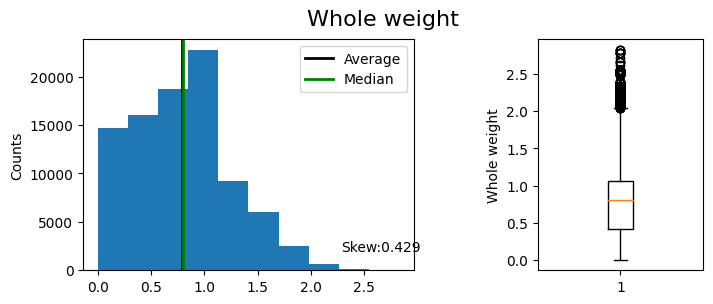

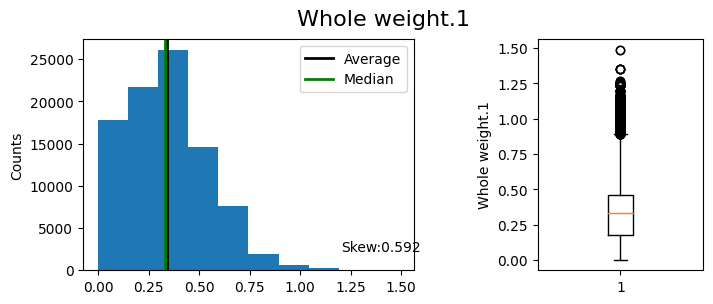

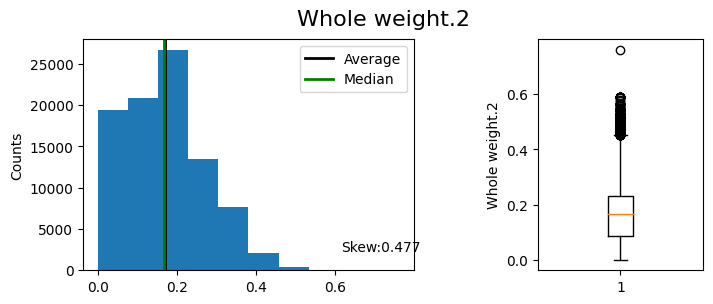

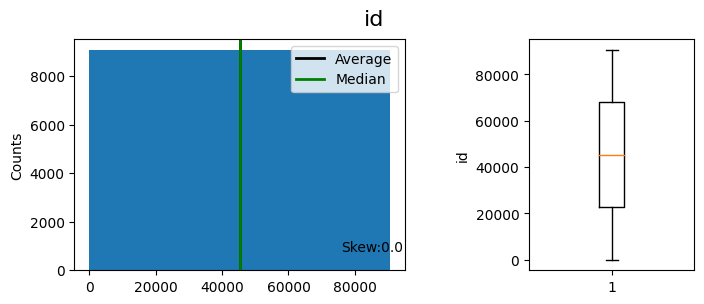

In [7]:
# make histogram and boxplot for all numeric features and target
for i in num_col:
    hist_box_fn(train_df, i)

id is uniform and will be dropped.  length and diameter are left skewed.  whole weight, whole weight 1, whole weight 2 and shell weight are normally distributed with high outliers.  Rings is right skewed.

In [8]:
# make list of skew for numeric columns
skew_list= []
for i in num_col:
    skew1= train_df[i].skew()
    skew_list.append(skew1)

# combine skew and column name into dictionary
skew_dict= dict(zip(num_col, skew_list))
print(skew_dict)

{'Diameter': -0.6952359660461651, 'Height': 0.30997506116618734, 'Length': -0.7320151933171143, 'Rings': 1.204272972602644, 'Shell weight': 0.4790924923513657, 'Whole weight': 0.42931626303752085, 'Whole weight.1': 0.5919732945442425, 'Whole weight.2': 0.4767333386805192, 'id': 0.0}


<Axes: >

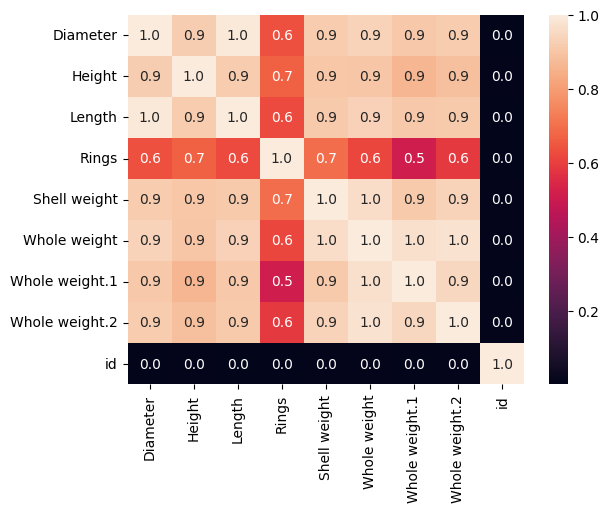

In [9]:
# look at correlation between numeric features

sns.heatmap(train_df[num_col].corr(), annot= True, fmt= '.1f')

high correlation between many features, need to drop many.

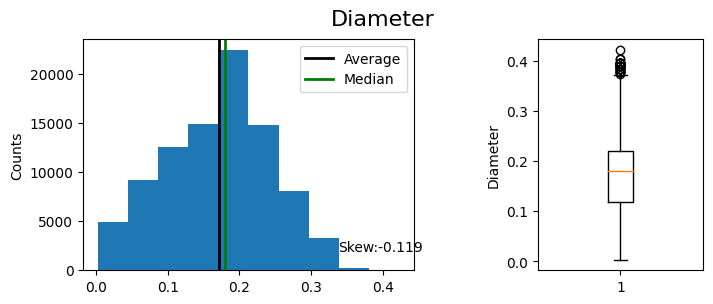

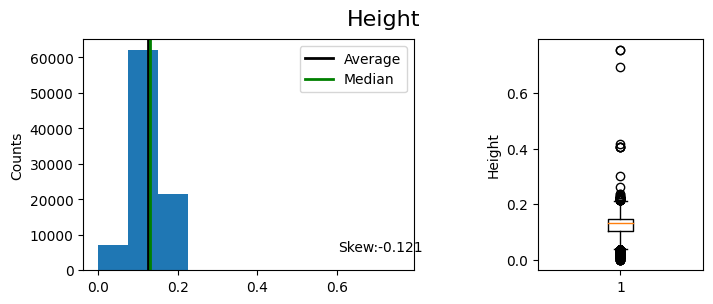

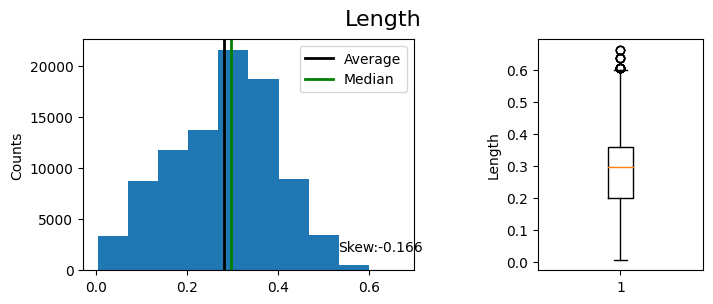

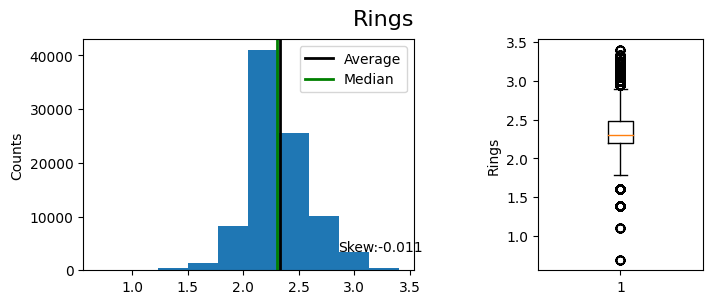

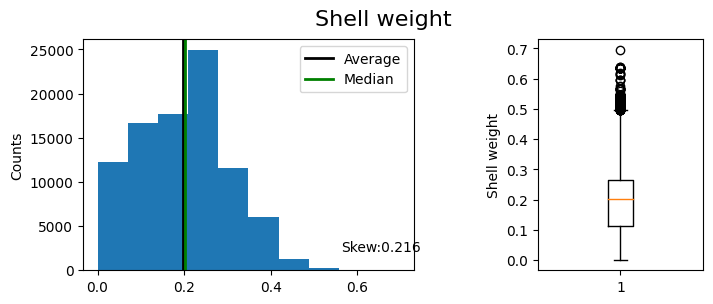

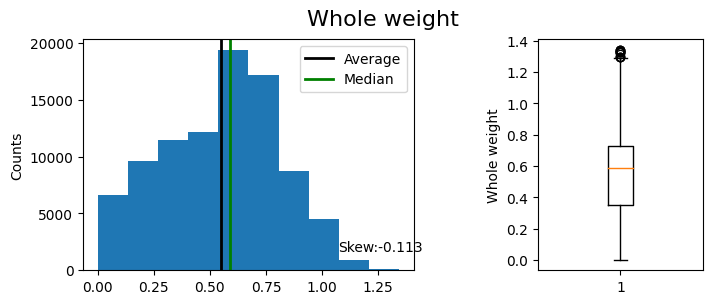

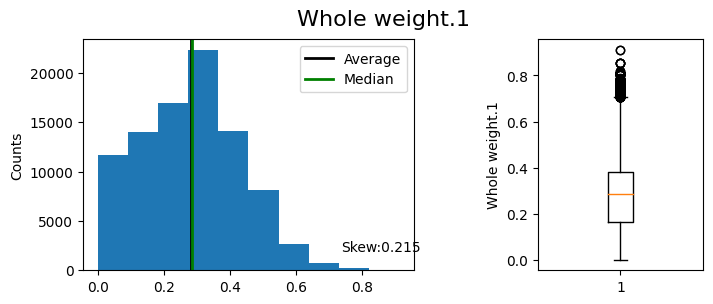

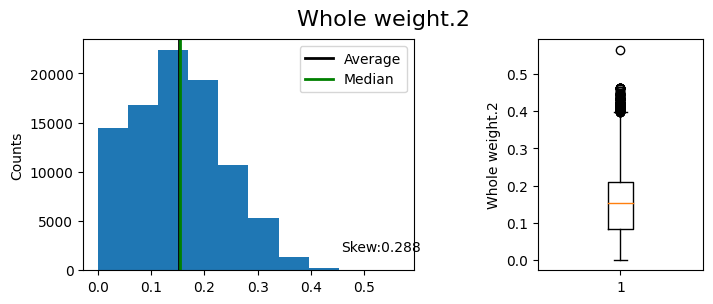

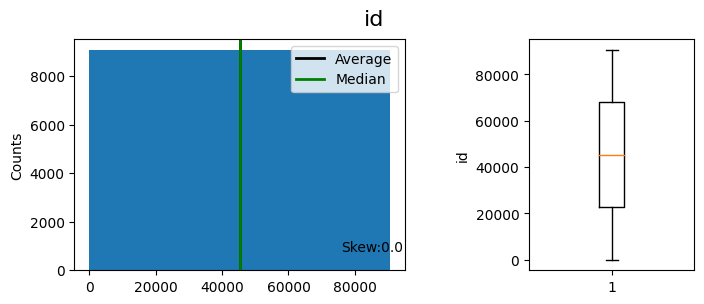

In [10]:
# transform right skew and left skew separately

for i in num_col:
    skew2= skew_dict[i]
    # transform positive skew with log transform
    if skew2 > 0:
        train_df[i]= np.log(1 + train_df[i])
    # transform negative skew with square transform
    elif skew2 < 0:
        train_df[i]= train_df[i]**2


#Look at graphs for transformed skewed columns
for j in num_col:
    hist_box_fn(train_df, j)



transform to reduce skew: for right skew used log transform and for left skew used square transform.

In [11]:
# categorical data
train_df['Sex'].describe().T

count     90615
unique        3
top           I
freq      33093
Name: Sex, dtype: object

<Axes: xlabel='Sex', ylabel='count'>

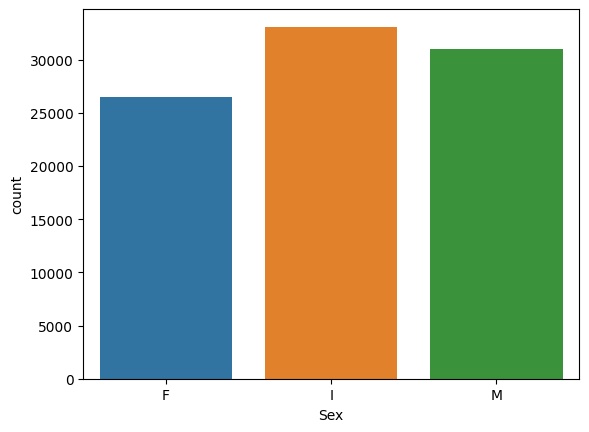

In [12]:
# visualize categorical data
sns.countplot(data= train_df, x= 'Sex')

Sex is balanced between 3 categories.

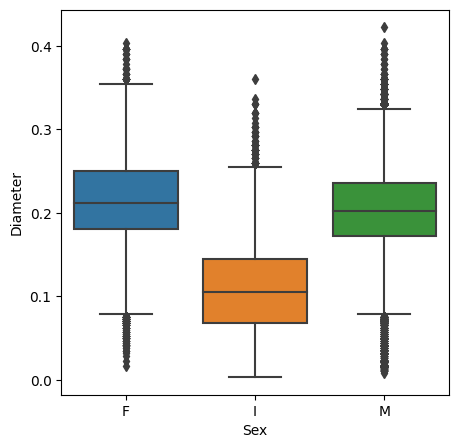

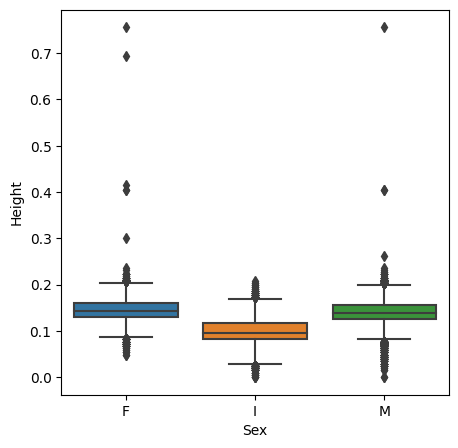

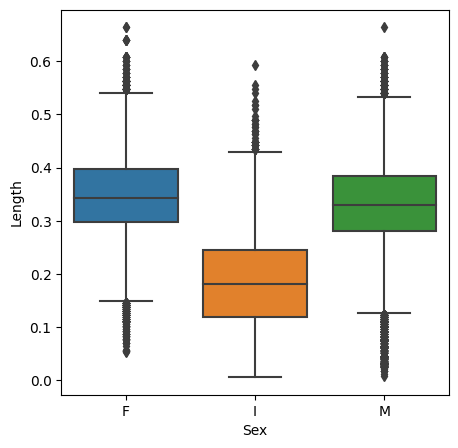

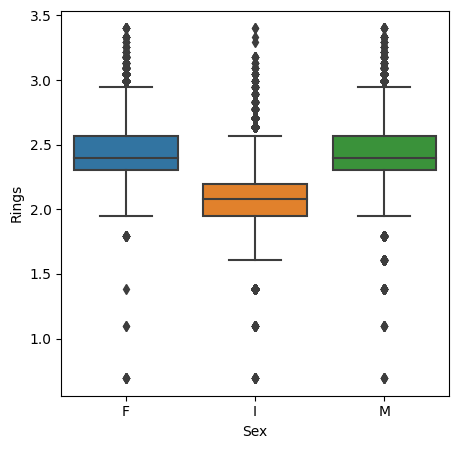

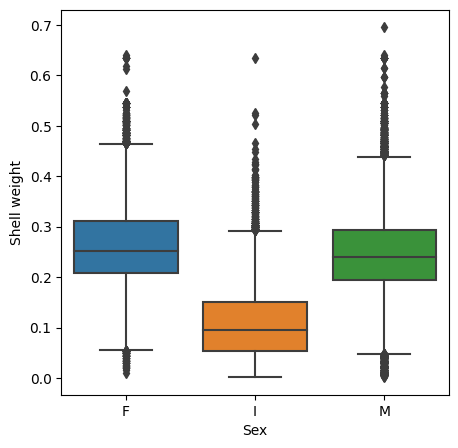

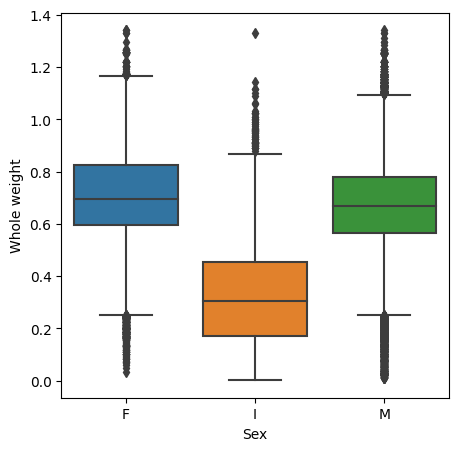

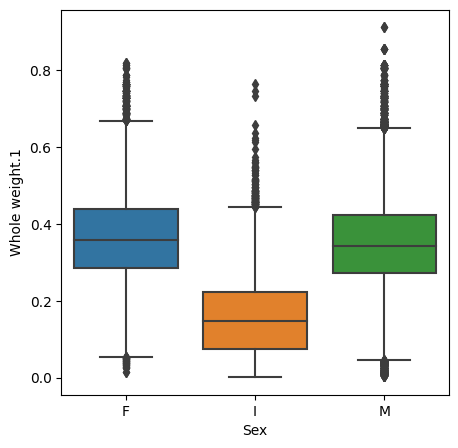

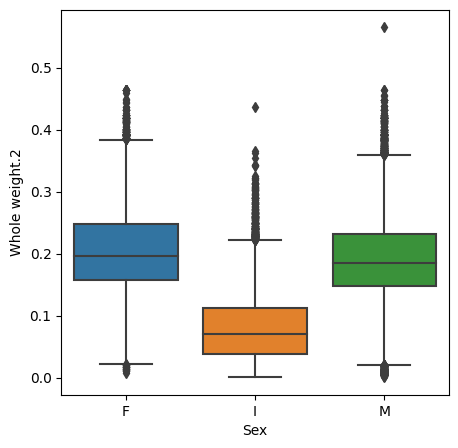

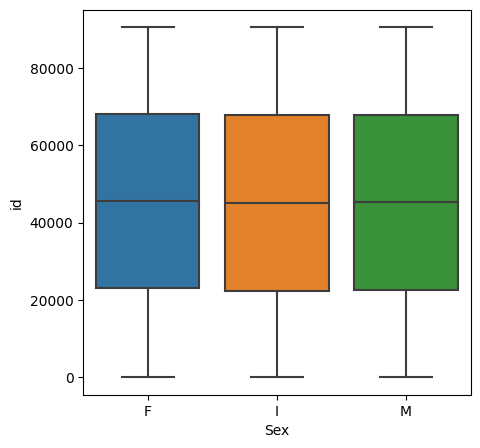

In [13]:
# look at boxplots split by sex for each numeric feature
for i in num_col:
    fig1= plt.figure(figsize= (5, 5))
    ax1= plt.gca()
    sns.boxplot(x= 'Sex', y= i, data= train_df)

    

id shows the same distribution for all sex. I as lower values than M or F for all numeric features except id.  M and F seem to have similar values for all numeric features and the target.

In [14]:
# columns to drop from training dataframe

drop_col= ['id', 'Whole weight.2', 'Diameter']

print('train_df shape is: {}'.format(train_df.shape))
train_df.drop(drop_col, axis= 1, inplace= True)
print('train_df shape is: {}'.format(train_df.shape))

train_df shape is: (90615, 10)
train_df shape is: (90615, 7)


In [15]:
# split data into training and validation
y1= train_df.loc[:, ['Rings']]
x1= train_df.drop(['Rings'], axis= 1)

x_train, x_val, y_train, y_val= train_test_split(x1, y1, test_size= 0.2, shuffle= True, random_state= 24)

# reset index
x_train= x_train.reset_index(drop= True)
x_val= x_val.reset_index(drop= True)
y_train= y_train.reset_index(drop= True)
y_val= y_val.reset_index(drop= True)

# look at shapes and dataframes
print('shape of x_train is:{}'.format(x_train.shape))
print(x_train.head())

print('-'*80)
print('shape of x_val is:{}'.format(x_val.shape))
print(x_val.head())

print('-'*80)
print('shape of y_train is:{}'.format(y_train.shape))
print(y_train.head())

print('-'*80)
print('shape of y_val is:{}'.format(y_val.shape))
print(y_val.head())

shape of x_train is:(72492, 6)
  Sex    Length    Height  Whole weight  Whole weight.1  Shell weight
0   F  0.156025  0.086178      0.284803        0.131467      0.089384
1   I  0.211600  0.104360      0.383219        0.190620      0.105261
2   M  0.342225  0.148420      0.720762        0.318090      0.303801
3   I  0.235225  0.117783      0.399782        0.195978      0.131905
4   I  0.360000  0.139762      0.721735        0.407796      0.253091
--------------------------------------------------------------------------------
shape of x_val is:(18123, 6)
  Sex    Length    Height  Whole weight  Whole weight.1  Shell weight
0   F  0.202500  0.108854      0.401457        0.157004      0.215111
1   I  0.184900  0.126633      0.266586        0.110199      0.086178
2   I  0.286225  0.117783      0.655445        0.317362      0.223144
3   I  0.144400  0.086178      0.195156        0.088469      0.061565
4   M  0.330625  0.131028      0.645531        0.337900      0.258511
-------------------

In [16]:
# scale the transformed data
x_scaler= MinMaxScaler()
y_scaler= MinMaxScaler()

num_feat= sorted(list(set(x_train.columns.tolist()) - set(['Sex'])))
#num_feat= sorted(x_train.columns.tolist())

# scale training
x_train_scaled= x_scaler.fit_transform(x_train[num_feat])
x_train_scaled= pd.DataFrame(x_train_scaled, columns= num_feat)
y_train_scaled= y_scaler.fit_transform(y_train)
y_train_scaled= pd.DataFrame(y_train_scaled, columns= ['Rings'])

# scale validation
x_val_scaled= x_scaler.transform(x_val[num_feat])
x_val_scaled= pd.DataFrame(x_val_scaled, columns= num_feat)
y_val_scaled= y_scaler.transform(y_val)
y_val_scaled= pd.DataFrame(y_val_scaled, columns= ['Rings'])

# look at new dataframes
print('x train scaled')
print(x_train_scaled.head())

print('-'*70)
print('x val scaled')
print(x_val_scaled.head())

print('-'*70)
print('y train scaled')
print(y_train_scaled.head())

print('-'*70)
print('y val scaled')
print(y_val_scaled.head())

x train scaled
     Height    Length  Shell weight  Whole weight  Whole weight.1
0  0.124328  0.228363      0.126609      0.211097        0.143295
1  0.150560  0.312747      0.149481      0.284559        0.208265
2  0.214125  0.511084      0.435503      0.536515        0.348268
3  0.169925  0.348618      0.187866      0.296922        0.214149
4  0.201634  0.538073      0.362448      0.537241        0.446793
----------------------------------------------------------------------
x val scaled
     Height    Length  Shell weight  Whole weight  Whole weight.1
0  0.157044  0.298930      0.307735      0.298173        0.171343
1  0.182692  0.272206      0.121990      0.197499        0.119936
2  0.169925  0.426055      0.319306      0.487760        0.347468
3  0.124328  0.210712      0.086533      0.144181        0.096069
4  0.189034  0.493471      0.370257      0.480359        0.370025
----------------------------------------------------------------------
y train scaled
      Rings
0  0.555410

In [17]:
# one hot encode categorical

# initialize encoder
encoder= OneHotEncoder(sparse_output= False, handle_unknown= 'ignore')

# one hot encode training
x_train_encoded= encoder.fit_transform(x_train.loc[:, ['Sex']])
x_train_encoded= pd.DataFrame(x_train_encoded, columns= encoder.get_feature_names_out())

# one hot encode validation
x_val_encoded= encoder.transform(x_val.loc[:, ['Sex']])
x_val_encoded= pd.DataFrame(x_val_encoded, columns= encoder.get_feature_names_out())

# look at encoded data
print('training one hot encoded')
print(x_train_encoded)

print('-'*80)
print('validation one hot encoded')
print(x_val_encoded)


training one hot encoded
       Sex_F  Sex_I  Sex_M
0        1.0    0.0    0.0
1        0.0    1.0    0.0
2        0.0    0.0    1.0
3        0.0    1.0    0.0
4        0.0    1.0    0.0
...      ...    ...    ...
72487    1.0    0.0    0.0
72488    0.0    1.0    0.0
72489    0.0    0.0    1.0
72490    1.0    0.0    0.0
72491    1.0    0.0    0.0

[72492 rows x 3 columns]
--------------------------------------------------------------------------------
validation one hot encoded
       Sex_F  Sex_I  Sex_M
0        1.0    0.0    0.0
1        0.0    1.0    0.0
2        0.0    1.0    0.0
3        0.0    1.0    0.0
4        0.0    0.0    1.0
...      ...    ...    ...
18118    1.0    0.0    0.0
18119    1.0    0.0    0.0
18120    1.0    0.0    0.0
18121    0.0    0.0    1.0
18122    1.0    0.0    0.0

[18123 rows x 3 columns]


In [18]:
# combine numeric and categorical features
# try transform only vs transform and scal

# training transform only
x_train_final_trans= pd.concat([x_train[num_feat], x_train_encoded], axis= 1)


# validation transform only
x_val_final_trans= pd.concat([x_val[num_feat], x_val_encoded], axis= 1)


# look at final features
print('training features')
print(x_train_final_trans.head())

print('-'*80)
print('validation features')
print(x_val_final_trans.head())


training features
     Height    Length  Shell weight  Whole weight  Whole weight.1  Sex_F  \
0  0.086178  0.156025      0.089384      0.284803        0.131467    1.0   
1  0.104360  0.211600      0.105261      0.383219        0.190620    0.0   
2  0.148420  0.342225      0.303801      0.720762        0.318090    0.0   
3  0.117783  0.235225      0.131905      0.399782        0.195978    0.0   
4  0.139762  0.360000      0.253091      0.721735        0.407796    0.0   

   Sex_I  Sex_M  
0    0.0    0.0  
1    1.0    0.0  
2    0.0    1.0  
3    1.0    0.0  
4    1.0    0.0  
--------------------------------------------------------------------------------
validation features
     Height    Length  Shell weight  Whole weight  Whole weight.1  Sex_F  \
0  0.108854  0.202500      0.215111      0.401457        0.157004    1.0   
1  0.126633  0.184900      0.086178      0.266586        0.110199    0.0   
2  0.117783  0.286225      0.223144      0.655445        0.317362    0.0   
3  0.086178 

In [19]:
# combine numeric and categorical features, scaled and transformed

# training transform only
x_train_final_scale= pd.concat([x_train_scaled, x_train_encoded], axis= 1)


# validation transform only
x_val_final_scale= pd.concat([x_val_scaled, x_val_encoded], axis= 1)


# look at final features
print('training features')
print(x_train_final_scale.head())

print('-'*80)
print('validation features')
print(x_val_final_scale.head())

training features
     Height    Length  Shell weight  Whole weight  Whole weight.1  Sex_F  \
0  0.124328  0.228363      0.126609      0.211097        0.143295    1.0   
1  0.150560  0.312747      0.149481      0.284559        0.208265    0.0   
2  0.214125  0.511084      0.435503      0.536515        0.348268    0.0   
3  0.169925  0.348618      0.187866      0.296922        0.214149    0.0   
4  0.201634  0.538073      0.362448      0.537241        0.446793    0.0   

   Sex_I  Sex_M  
0    0.0    0.0  
1    1.0    0.0  
2    0.0    1.0  
3    1.0    0.0  
4    1.0    0.0  
--------------------------------------------------------------------------------
validation features
     Height    Length  Shell weight  Whole weight  Whole weight.1  Sex_F  \
0  0.157044  0.298930      0.307735      0.298173        0.171343    1.0   
1  0.182692  0.272206      0.121990      0.197499        0.119936    0.0   
2  0.169925  0.426055      0.319306      0.487760        0.347468    0.0   
3  0.124328 

In [20]:
## PCA
pca= PCA(random_state= 24, n_components= 5)

# apply PCA to scaled data
x_train_final_scale= pca.fit_transform(x_train_final_scale)
x_train_final_scale= pd.DataFrame(x_train_final_scale)

x_val_final_scale= pca.transform(x_val_final_scale)
x_val_final_scale= pd.DataFrame(x_val_final_scale)

# look at component importance
print(pca.explained_variance_)

# look at final features
print('training features')
print(x_train_final_scale.head())

print('-'*80)
print('validation features')
print(x_val_final_scale.head())

[0.41145763 0.31464387 0.05347704 0.00180653 0.00098797]
training features
          0         1         2         3         4
0 -0.159969  0.748010 -0.544846 -0.017117  0.010881
1  0.801352 -0.065120  0.111957 -0.026220 -0.014774
2 -0.577456 -0.600572  0.027430  0.086410  0.006745
3  0.782081 -0.060737  0.154277 -0.000515 -0.027690
4  0.609861 -0.022339  0.536700 -0.025091  0.003243
--------------------------------------------------------------------------------
validation features
          0         1         2         3         4
0 -0.234319  0.764949 -0.382549  0.100660  0.036864
1  0.849966 -0.075851  0.003277  0.016317 -0.040273
2  0.672684 -0.036295  0.395952  0.008332  0.033067
3  0.889116 -0.084648 -0.082785 -0.000263 -0.015353
4 -0.551794 -0.606483 -0.027327  0.020288  0.002978


In [21]:
# function to fit, predict and evaluate models for scaled data

def metric_scale_fn(xtrain1, ytrain1, xval1, yval1, model1, name1):
    # reduce dimension of y
    ytrain1= ytrain1.squeeze()
    yval1= yval1.squeeze()
    # convert to numpy
    ytrain1= ytrain1.to_numpy()
    yval1= yval1.to_numpy()
    # fit model
    model1.fit(xtrain1, ytrain1)
    
    # predict training
    y_train_pred= model1.predict(xtrain1)

    # predict validation
    y_val_pred= model1.predict(xval1)

    y_list= [ytrain1, y_train_pred, yval1, y_val_pred]

    # loop to reverse minmaxscaling and log transform
    y_final= []
    for i in y_list:
        # reshape from 2d to 1d
        y_reshape= i.reshape(-1, 1)
        # inverse minmaxscaling
        y_inv_scale= y_scaler.inverse_transform(y_reshape)
        # reshape from 2d to 1d
        y_reshape2= y_inv_scale.reshape(-1)
        # inverse log(1 + x) transform
        y_inv_log= np.exp(y_reshape2) - 1
        y_series= pd.Series(y_inv_log, name= 'Rings')
        y_final.append(y_series)

    # get training rmsle
    train_rmsle= np.sqrt(mean_squared_log_error(y_final[0], y_final[1]))
    val_rmsle= np.sqrt(mean_squared_log_error(y_final[2], y_final[3]))
    print(y_final[3].head())
# make evaluation dictionary
    dict1= {'Model':[name1], 'Train_RMSLE':[train_rmsle], 'Val_RMSLE':[val_rmsle]}
    df1= pd.DataFrame.from_dict(data= dict1)
    return df1
    

In [22]:
 #function to fit, predict and evaluate models for log transformed data

def metric_trans_fn(xtrain1, ytrain1, xval1, yval1, model1, name1):
    # reduce dimension of y
    ytrain1= ytrain1.squeeze()
    yval1= yval1.squeeze()

    # fit model
    model1.fit(xtrain1, ytrain1)
    
    # predict training
    y_train_pred= model1.predict(xtrain1)

    # predict validation
    y_val_pred= model1.predict(xval1)

    y_list= [ytrain1, y_train_pred, yval1, y_val_pred]

    # loop to reverse log transform
    y_final= []
    for i in y_list:
        # inverse log(1 + x) transform
        y_inv_log= np.exp(i) - 1
        y_series= pd.Series(y_inv_log, name= 'Rings')
        y_final.append(y_series)

    # get training rmsle
    train_rmsle= np.sqrt(mean_squared_log_error(y_final[0], y_final[1]))
    val_rmsle= np.sqrt(mean_squared_log_error(y_final[2], y_final[3]))
    print(y_final[3].head())
# make evaluation dictionary
    dict1= {'Model':[name1], 'Train_RMSLE':[train_rmsle], 'Val_RMSLE':[val_rmsle]}
    df1= pd.DataFrame.from_dict(data= dict1)
    return df1

In [23]:
# model 1- linear regression

lin_reg= LinearRegression()

# transformed data
lin_reg_df_trans= metric_trans_fn(x_train_final_trans, y_train, x_val_final_trans, y_val, lin_reg, 'linear reg')

print(lin_reg_df_trans)

# scaled data
lin_reg_df_scale= metric_scale_fn(x_train_final_scale, y_train_scaled, x_val_final_scale, y_val_scaled, lin_reg, 'linear reg')

print(lin_reg_df_scale)

0    10.630681
1     8.185649
2     9.407853
3     6.648279
4    10.317174
Name: Rings, dtype: float64
        Model  Train_RMSLE  Val_RMSLE
0  linear reg     0.164748   0.163435
0    11.419866
1     7.525184
2     9.077892
3     6.754687
4    10.956109
Name: Rings, dtype: float64
        Model  Train_RMSLE  Val_RMSLE
0  linear reg     0.171103   0.168758


In [24]:
# model 2- elastic net

elastic1= ElasticNet(random_state= 24, alpha= 0.0001)

# transformed data
elastic_df_trans= metric_trans_fn(x_train_final_trans, y_train, x_val_final_trans, y_val, elastic1, 'Elastic Net')

trans_df= pd.concat([lin_reg_df_trans, elastic_df_trans], axis= 0)
print('transformed data')
print(trans_df)

# scaled data
elastic_df_scale= metric_scale_fn(x_train_final_scale, y_train_scaled, x_val_final_scale, y_val_scaled, elastic1, 'Elastic Net')
scale_df= pd.concat([lin_reg_df_scale, elastic_df_scale], axis= 0)

print('-'*80)
print('scaled data')
print(scale_df)

0    10.585150
1     7.910648
2     9.471222
3     6.658180
4    10.422340
Name: Rings, dtype: float64
transformed data
         Model  Train_RMSLE  Val_RMSLE
0   linear reg     0.164748   0.163435
0  Elastic Net     0.165305   0.163309
0    11.322685
1     7.458829
2     9.106035
3     6.742232
4    10.929512
Name: Rings, dtype: float64
--------------------------------------------------------------------------------
scaled data
         Model  Train_RMSLE  Val_RMSLE
0   linear reg     0.171103   0.168758
0  Elastic Net     0.171267   0.168995


In [25]:
# model 3- decision tree

tree1= DecisionTreeRegressor(random_state= 24)

# transformed data
tree_df_trans= metric_trans_fn(x_train_final_trans, y_train, x_val_final_trans, y_val, tree1, 'Decision Tree')

trans_df= pd.concat([trans_df, tree_df_trans], axis= 0)
print('transformed data')
print(trans_df)

# scaled data
tree_df_scale= metric_scale_fn(x_train_final_scale, y_train_scaled, x_val_final_scale, y_val_scaled, tree1, 'Decision Tree')
scale_df= pd.concat([scale_df, tree_df_scale], axis= 0)

print('-'*80)
print('scaled data')
print(scale_df)

0    12.0
1     6.0
2     8.0
3     7.0
4    10.0
Name: Rings, dtype: float64
transformed data
           Model  Train_RMSLE  Val_RMSLE
0     linear reg     0.164748   0.163435
0    Elastic Net     0.165305   0.163309
0  Decision Tree     0.010755   0.216694
0    12.0
1     8.0
2    10.0
3     7.0
4    13.0
Name: Rings, dtype: float64
--------------------------------------------------------------------------------
scaled data
           Model  Train_RMSLE  Val_RMSLE
0     linear reg     0.171103   0.168758
0    Elastic Net     0.171267   0.168995
0  Decision Tree     0.010755   0.216759


decision tree is overfit.

In [26]:
# model 4- random forest

forest1= RandomForestRegressor(random_state= 24)

# transformed data
forest_df_trans= metric_trans_fn(x_train_final_trans, y_train, x_val_final_trans, y_val, forest1, 'Random Forest')
trans_df= pd.concat([trans_df, forest_df_trans], axis= 0)
print('transformed data')
print(trans_df)

# scaled data
forest_df_scale= metric_scale_fn(x_train_final_scale, y_train_scaled, x_val_final_scale, y_val_scaled, forest1, 'Random Forest')
scale_df= pd.concat([scale_df, forest_df_scale], axis= 0)

print('-'*80)
print('scaled data')
print(scale_df)

0    12.166863
1     8.803422
2    11.100768
3     6.723481
4    12.125562
Name: Rings, dtype: float64
transformed data
           Model  Train_RMSLE  Val_RMSLE
0     linear reg     0.164748   0.163435
0    Elastic Net     0.165305   0.163309
0  Decision Tree     0.010755   0.216694
0  Random Forest     0.058992   0.154451
0    12.794024
1     7.973605
2    10.893310
3     6.559177
4    11.261858
Name: Rings, dtype: float64
--------------------------------------------------------------------------------
scaled data
           Model  Train_RMSLE  Val_RMSLE
0     linear reg     0.171103   0.168758
0    Elastic Net     0.171267   0.168995
0  Decision Tree     0.010755   0.216759
0  Random Forest     0.060871   0.159327


random forest is overfit.

In [27]:
# model 5- xgboost

boost1= XGBRegressor(random_state= 24)

# transformed data
boost_df_trans= metric_trans_fn(x_train_final_trans, y_train, x_val_final_trans, y_val, boost1, 'xgboost')
trans_df= pd.concat([trans_df, boost_df_trans], axis= 0)
print('transformed data')
print(trans_df)

# scaled data
boost_df_scale= metric_scale_fn(x_train_final_scale, y_train_scaled, x_val_final_scale, y_val_scaled, boost1, 'xgboost')
scale_df= pd.concat([scale_df, boost_df_scale], axis= 0)

print('-'*80)
print('scaled data')
print(scale_df)

0    14.653275
1     8.624802
2    10.930178
3     6.746168
4    10.969193
Name: Rings, dtype: float32
transformed data
           Model  Train_RMSLE  Val_RMSLE
0     linear reg     0.164748   0.163435
0    Elastic Net     0.165305   0.163309
0  Decision Tree     0.010755   0.216694
0  Random Forest     0.058992   0.154451
0        xgboost     0.138979   0.149714
0    14.809866
1     7.575034
2     9.723887
3     6.645370
4    11.389807
Name: Rings, dtype: float32
--------------------------------------------------------------------------------
scaled data
           Model  Train_RMSLE  Val_RMSLE
0     linear reg     0.171103   0.168758
0    Elastic Net     0.171267   0.168995
0  Decision Tree     0.010755   0.216759
0  Random Forest     0.060871   0.159327
0        xgboost     0.142110   0.154213


In [28]:
# model 6- light gbm

light1= LGBMRegressor(random_state= 24, objective= 'regression')

# transformed data
light_df_trans= metric_trans_fn(x_train_final_trans, y_train, x_val_final_trans, y_val, light1, 'lightGBM')
trans_df= pd.concat([trans_df, light_df_trans], axis= 0)
print('transformed data')
print(trans_df)

# scaled data
light_df_scale= metric_scale_fn(x_train_final_scale, y_train_scaled, x_val_final_scale, y_val_scaled, light1, 'lightGBM')
scale_df= pd.concat([scale_df, light_df_scale], axis= 0)

print('-'*80)
print('scaled data')
print(scale_df)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 964
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 8
[LightGBM] [Info] Start training from score 2.328960
0    12.088519
1     8.323967
2    10.113907
3     6.692226
4    11.448268
Name: Rings, dtype: float64
transformed data
           Model  Train_RMSLE  Val_RMSLE
0     linear reg     0.164748   0.163435
0    Elastic Net     0.165305   0.163309
0  Decision Tree     0.010755   0.216694
0  Random Forest     0.058992   0.154451
0        xgboost     0.138979   0.149714
0       lightGBM     0.146710   0.148679
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002018 seconds.
You c

In [29]:
# model 7- mlpregressor 

network1= MLPRegressor(random_state= 24)

# transformed data
neural_df_trans= metric_trans_fn(x_train_final_trans, y_train, x_val_final_trans, y_val, network1, 'Neural network')
trans_df= pd.concat([trans_df, neural_df_trans], axis= 0)
print('transformed data')
print(trans_df)

# scaled data
neural_df_scale= metric_scale_fn(x_train_final_scale, y_train_scaled, x_val_final_scale, y_val_scaled, network1, 'Neural network')
scale_df= pd.concat([scale_df, neural_df_scale], axis= 0)

print('-'*80)
print('scaled data')
print(scale_df)

0    12.276536
1     7.703020
2    10.395916
3     6.753295
4    11.164978
Name: Rings, dtype: float64
transformed data
            Model  Train_RMSLE  Val_RMSLE
0      linear reg     0.164748   0.163435
0     Elastic Net     0.165305   0.163309
0   Decision Tree     0.010755   0.216694
0   Random Forest     0.058992   0.154451
0         xgboost     0.138979   0.149714
0        lightGBM     0.146710   0.148679
0  Neural network     0.156281   0.154472
0    13.806348
1     7.507673
2     9.965195
3     6.780387
4    11.458488
Name: Rings, dtype: float64
--------------------------------------------------------------------------------
scaled data
            Model  Train_RMSLE  Val_RMSLE
0      linear reg     0.171103   0.168758
0     Elastic Net     0.171267   0.168995
0   Decision Tree     0.010755   0.216759
0   Random Forest     0.060871   0.159327
0         xgboost     0.142110   0.154213
0        lightGBM     0.150695   0.152714
0  Neural network     0.155091   0.153502


Best performance is lightgbm on transformed data

In [30]:
# bayesian optimization of lightgbm

light1= LGBMRegressor(random_state= 24, objective= 'regression')

space1= {'num_leaves':Integer(20, 70), 
        'max_bin':Integer(250, 400), 
        'learning_rate':Real(0.001, 0.1, prior= 'log-uniform'), 
        'num_iterations':Integer(100, 600)}

light_opt= BayesSearchCV(estimator= light1, search_spaces= space1, cv= 3, n_iter= 100, random_state= 24, 
                        verbose= 0)

light_opt.fit(x_train_final_trans, y_train)

print('best parameters are: {}'.format(light_opt.best_params_))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1125
[LightGBM] [Info] Number of data points in the train set: 48328, number of used features: 8
[LightGBM] [Info] Start training from score 2.329361
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1124
[LightGBM] [Info] Number of data points in the train set: 48328, number of used features: 8
[LightGBM] [Info] Start training from score 2.328881
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [In

In [31]:
# check performance of optimized model
light_opt1= LGBMRegressor(random_state= 24, objective= 'regression', learning_rate= light_opt.best_params_['learning_rate'], 
                         num_leaves= light_opt.best_params_['num_leaves'], max_bin= light_opt.best_params_['max_bin'], 
                         num_iterations= light_opt.best_params_['num_iterations'])

# transformed data
light_opt1_df_trans= metric_trans_fn(x_train_final_trans, y_train, x_val_final_trans, y_val, light_opt1, 'Optimized LightGBM')
trans_df= pd.concat([trans_df, light_opt1_df_trans], axis= 0)
print('transformed data')
print(trans_df)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1397
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 8
[LightGBM] [Info] Start training from score 2.328960
0    12.196749
1     8.696235
2    10.627245
3     6.690699
4    11.388627
Name: Rings, dtype: float64
transformed data
                Model  Train_RMSLE  Val_RMSLE
0          linear reg     0.164748   0.163435
0         Elastic Net     0.165305   0.163309
0       Decision Tree     0.010755   0.216694
0       Random Forest     0.058992   0.154451
0             xgboost     0.138979   0.149714
0            lightGBM     0.146710   0.148679
0      Neural network     0.156281   0.154472
0  Optimized LightGBM     0.141292   0.147650


In [32]:
# load test data
test_df= pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')

print('Test Data')
print(test_df.head())
print('Shape of test data is: {}'.format(test_df.shape))

# check for null
print(test_df.info())


Test Data
      id Sex  Length  Diameter  Height  Whole weight  Whole weight.1  \
0  90615   M   0.645     0.475   0.155        1.2380          0.6185   
1  90616   M   0.580     0.460   0.160        0.9830          0.4785   
2  90617   M   0.560     0.420   0.140        0.8395          0.3525   
3  90618   M   0.570     0.490   0.145        0.8740          0.3525   
4  90619   I   0.415     0.325   0.110        0.3580          0.1575   

   Whole weight.2  Shell weight  
0          0.3125        0.3005  
1          0.2195        0.2750  
2          0.1845        0.2405  
3          0.1865        0.2350  
4          0.0670        0.1050  
Shape of test data is: (60411, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60411 entries, 0 to 60410
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              60411 non-null  int64  
 1   Sex             60411 non-null  object 
 2   Length          60411 non-

No null values in test dataset.  most features are numeric.  Sex is only categorical feature.

In [33]:
# need to drop columns test
test_df1= test_df.drop(drop_col, axis= 1)


print('Test dataframe')
print(test_df1.head())

Test dataframe
  Sex  Length  Height  Whole weight  Whole weight.1  Shell weight
0   M   0.645   0.155        1.2380          0.6185        0.3005
1   M   0.580   0.160        0.9830          0.4785        0.2750
2   M   0.560   0.140        0.8395          0.3525        0.2405
3   M   0.570   0.145        0.8740          0.3525        0.2350
4   I   0.415   0.110        0.3580          0.1575        0.1050


In [34]:
# need to transform skewed test columns
test_num_col= sorted(test_df1.select_dtypes(include= np.number).columns)

for i in test_num_col:
    skew3= test_df1[i].skew()
    print('Skew of {} is: {}'.format(i, skew3))
    # transform positive skew with log transform
    if skew3 > 0:
        test_df1[i]= np.log(1 + test_df1[i])
    # transform negative skew with square transform
    elif skew3 < 0:
        test_df1[i]= test_df1[i]**2

# look at transformed features
print(test_df1.head())

Skew of Height is: 0.5545061267402694
Skew of Length is: -0.7345648768364925
Skew of Shell weight is: 0.46852363250301515
Skew of Whole weight is: 0.4356635205359348
Skew of Whole weight.1 is: 0.5932057561862106
  Sex    Length    Height  Whole weight  Whole weight.1  Shell weight
0   M  0.416025  0.144100      0.805583        0.481500      0.262749
1   M  0.336400  0.148420      0.684611        0.391028      0.242946
2   M  0.313600  0.131028      0.609494        0.301955      0.215515
3   M  0.324900  0.135405      0.628075        0.301955      0.211071
4   I  0.172225  0.104360      0.306013        0.146263      0.099845


In [35]:
# need to split training into x and y

train_all_y= train_df['Rings']
train_all_x= train_df.drop(['Rings'], axis= 1)

print(train_all_x.head())
print(train_all_y.head())

  Sex    Length    Height  Whole weight  Whole weight.1  Shell weight
0   F  0.302500  0.139762      0.571827        0.284050      0.215111
1   F  0.396900  0.135405      0.756122        0.377066      0.277632
2   I  0.025600  0.024693      0.020783        0.005485      0.004988
3   M  0.354025  0.139762      0.649456        0.318817      0.223144
4   I  0.308025  0.122218      0.577736        0.314446      0.180236
0    2.484907
1    2.484907
2    1.945910
3    2.397895
4    2.302585
Name: Rings, dtype: float64


In [36]:
# need to one hot encode training and test

encoder1= OneHotEncoder(sparse_output= False, handle_unknown= 'ignore')

# fit and transform training
train_all_x_encoded= encoder1.fit_transform(train_all_x.loc[:, ['Sex']])
train_all_x_encoded= pd.DataFrame(train_all_x_encoded, columns= encoder1.get_feature_names_out())

# transform test
test_all_x_encoded= encoder1.transform(test_df1.loc[:, ['Sex']])
test_all_x_encoded= pd.DataFrame(test_all_x_encoded, columns= encoder1.get_feature_names_out())

# look at encoded dataframes
print('Training encoded')
print(train_all_x_encoded.head())

print('-'*80)
print('Test encoded')
print(test_all_x_encoded.head())

Training encoded
   Sex_F  Sex_I  Sex_M
0    1.0    0.0    0.0
1    1.0    0.0    0.0
2    0.0    1.0    0.0
3    0.0    0.0    1.0
4    0.0    1.0    0.0
--------------------------------------------------------------------------------
Test encoded
   Sex_F  Sex_I  Sex_M
0    0.0    0.0    1.0
1    0.0    0.0    1.0
2    0.0    0.0    1.0
3    0.0    0.0    1.0
4    0.0    1.0    0.0


In [37]:
# recombine categorical and numeric features

train_all_x_final= pd.concat([train_all_x[test_num_col], train_all_x_encoded], axis= 1)
test_all_x_final= pd.concat([test_df1[test_num_col], test_all_x_encoded], axis= 1)

# look at final dataframes
print('Training encoded')
print(train_all_x_final.head())

print('-'*80)
print('Test encoded')
print(test_all_x_final.head())

Training encoded
     Height    Length  Shell weight  Whole weight  Whole weight.1  Sex_F  \
0  0.139762  0.302500      0.215111      0.571827        0.284050    1.0   
1  0.135405  0.396900      0.277632      0.756122        0.377066    1.0   
2  0.024693  0.025600      0.004988      0.020783        0.005485    0.0   
3  0.139762  0.354025      0.223144      0.649456        0.318817    0.0   
4  0.122218  0.308025      0.180236      0.577736        0.314446    0.0   

   Sex_I  Sex_M  
0    0.0    0.0  
1    0.0    0.0  
2    1.0    0.0  
3    0.0    1.0  
4    1.0    0.0  
--------------------------------------------------------------------------------
Test encoded
     Height    Length  Shell weight  Whole weight  Whole weight.1  Sex_F  \
0  0.144100  0.416025      0.262749      0.805583        0.481500    0.0   
1  0.148420  0.336400      0.242946      0.684611        0.391028    0.0   
2  0.131028  0.313600      0.215515      0.609494        0.301955    0.0   
3  0.135405  0.32490

In [38]:
# fit training data using optimized lightGBM model

light_opt1= LGBMRegressor(random_state= 24, objective= 'regression', learning_rate= light_opt.best_params_['learning_rate'], 
                         num_leaves= light_opt.best_params_['num_leaves'], max_bin= light_opt.best_params_['max_bin'], 
                         num_iterations= light_opt.best_params_['num_iterations'])

# fit on training data
light_opt1.fit(train_all_x_final, train_all_y)

# predict on test data
y_pred_test= light_opt1.predict(test_all_x_final)
y_pred_test= pd.Series(y_pred_test, name= 'Rings')

# inverse transform prediction
y_pred_test= np.exp(y_pred_test) - 1

# format prediction for submission
sub_df= pd.concat([test_df['id'], y_pred_test], axis= 1)


# submit to competition
sub_df.to_csv('/kaggle/working/submission.csv', index= False)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1403
[LightGBM] [Info] Number of data points in the train set: 90615, number of used features: 8
[LightGBM] [Info] Start training from score 2.328960
